#### Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем. 2*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag. 3*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [135]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [136]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [137]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [138]:
class Tree:

    def __init__(self, max_depth=7, max_leaves=20, quality_criteria="Gini", min_leaf=1):
        self.max_depth = max_depth
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaves
        self.quality_criteria = quality_criteria
        self.min_leaf = min_leaf
        self.vote = []
        self.tree = None

    def gini(self, labels):  # Расчет критерия Джини
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity

    def entropy(self, labels):  # Расчет энтропии
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        entropy = 0
        for label in classes:
            p = classes[label] / len(labels)
            entropy -= p * np.log2(p)

        return entropy

    def quality_gini(self, left_labels, right_labels, current_gini):  # Расчет качества по Джани

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)

    def quality_entropy(self, left_labels, right_labels, current_entropy):  # Расчет качества по Энтропии

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_entropy - p * self.entropy(left_labels) - (1 - p) * self.entropy(right_labels)

    def split(self, data, labels, index, t):  # Разбиение датасета в узле

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    # создание подвыборки для обучения дерева
    def get_subsample(self, len_sample):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(len_sample)]

        len_subsample = int(np.sqrt(len_sample))
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample

    def find_best_split(self, data, labels):  # Нахождение наилучшего разбиения

        quality_function = self.quality_entropy if self.quality_criteria == "Entropy" else self.quality_gini
        current_quality_metric = self.entropy(labels) if self.quality_criteria == "Entropy" else self.gini(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = self.get_subsample(n_features)

        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = quality_function(true_labels, false_labels, current_quality_metric)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, labels):

        quality, t, index = self.find_best_split(data, labels)
        #     print(quality, t, index)

        # Базовый случай (3) - прекращаем рекурсию, когда достигнута максимальное число листьев
        # if len(self.leaves) >= self.max_leaves - 1:
        #    self.leaves.append(Leaf(data, labels))
        #    return Leaf(data, labels)

        # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
        # if self.depth >= self.max_depth:
        #    self.leaves.append(Leaf(data, labels))
        #    return Leaf(data, labels)

        # self.depth += 1

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    def fit(tree, data, labels):
        tree.tree = tree.build_tree(data, labels)
        return tree

    def tree_vote(tree, data):

        classes = []
        for obj in data:
            prediction = tree.classify_object(obj, tree.tree)
            classes.append(prediction)
        tree.vote = classes

        return classes



In [139]:
# Реализуем класс случайного леса
random.seed(42)


class RandomForestClassifier:

    def __init__(self, n_trees,  # количествоо деревьев в случайном лесу
                 max_depth=100,  # максимальная глубина деревьев
                 max_leaves=200,  # максимальное количество листьев в деревьях
                 quality_criteria="Gini",  # критерий оценки качества при посторении деревьев
                 min_leaf=1):  # минимальное число объектов в листе, до которого строятся деревья
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_leaves = 200
        self.quality_criteria = "Gini"
        self.min_leaf = min_leaf
        self.trees = []  # список построенных деревьев
        self.bootstrap = []  # формирование бутстрап-выборок и подмножества признаков
        # для нахождения разбиения в узле. Число выборок = числу деревьев в лесу
        self.sample_indexes=None

    # формирование бутстрап-выборок и подмножества признаков
    # для нахождения разбиения в узле. Число выборок = числу деревьев в лесу
    def get_bootstrap(self, data, labels, N):
        n_samples = data.shape[0]
        indexes=[] # будем записывать номера индексов данных, вошедших в бутсртап-выборки

        for i in range(N):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)

            for j in range(n_samples):
                sample_index = random.randint(0, n_samples - 1)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
                indexes.append(sample_index)
            self.bootstrap.append((b_data, b_labels))
            self.sample_indexes=np.unique(np.array(indexes))

        return self
    
  

    # функция построения деревьев в лесу
    def fit(self, data, labels):
        forest = []
        bootstrap = self.get_bootstrap(data, labels, self.n_trees)

        for b_data, b_labels in self.bootstrap:
            new_tree = Tree(self.min_leaf,
                            self.quality_criteria,
                            self.max_leaves,
                            self.max_depth)

            new_tree.fit(b_data, b_labels)
            self.trees.append(new_tree)

        return self

    # предсказание голосованием деревьев
    def predict(self, data):

        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.trees:
            tree.tree_vote(data)
            predictions.append(tree.vote)

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions


In [140]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [141]:
# Визуализируем дерево на графике 

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def print_vizual (train_data, test_data, forest, train_accuracy, test_accuracy,n_forests):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(forest.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy при n={n_forests} деревьев={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy при n={n_forests} деревьев={test_accuracy:.2f}')

In [142]:
# сгенерируем данные
n_samples=1000
classification_data, classification_labels = datasets.make_classification(n_samples=n_samples, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state = 67)

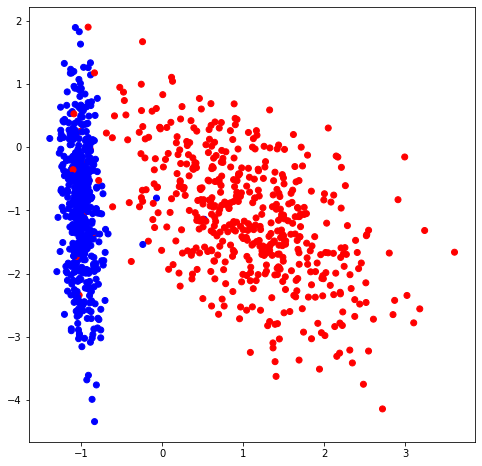

In [143]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [144]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

Сформируем случайные леса из 1, 3, 10 и 50, 100, 200 деревьев

In [145]:
n_forests = [1,3,10,50,100,200]

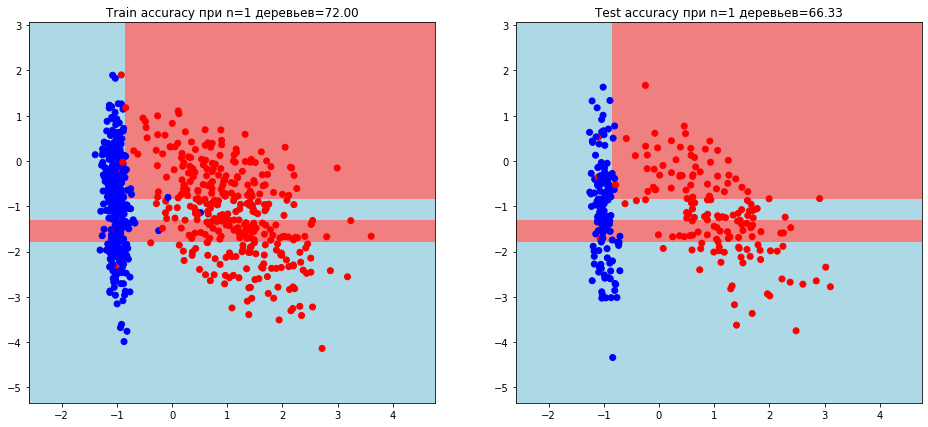

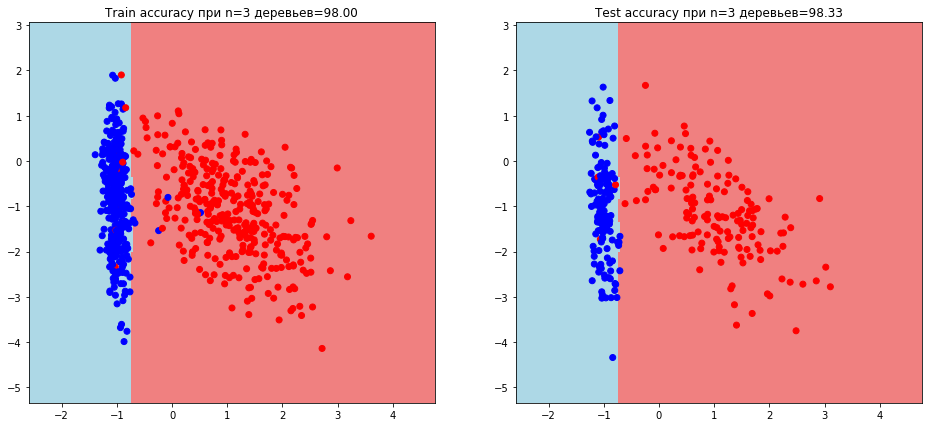

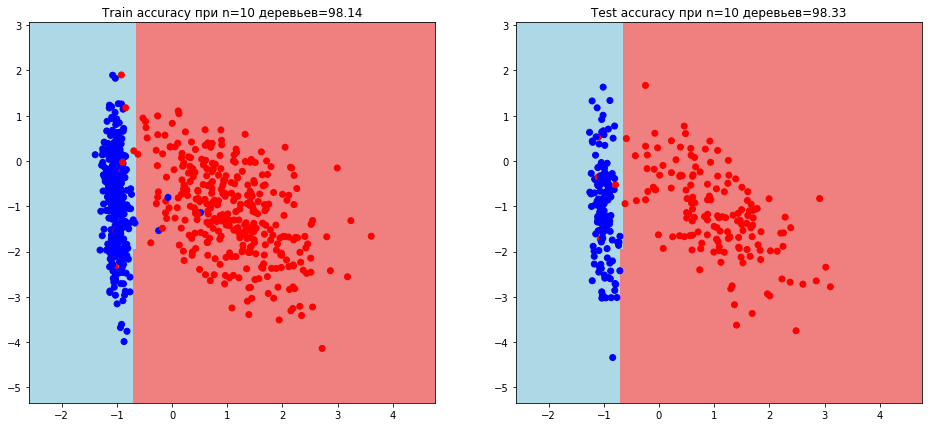

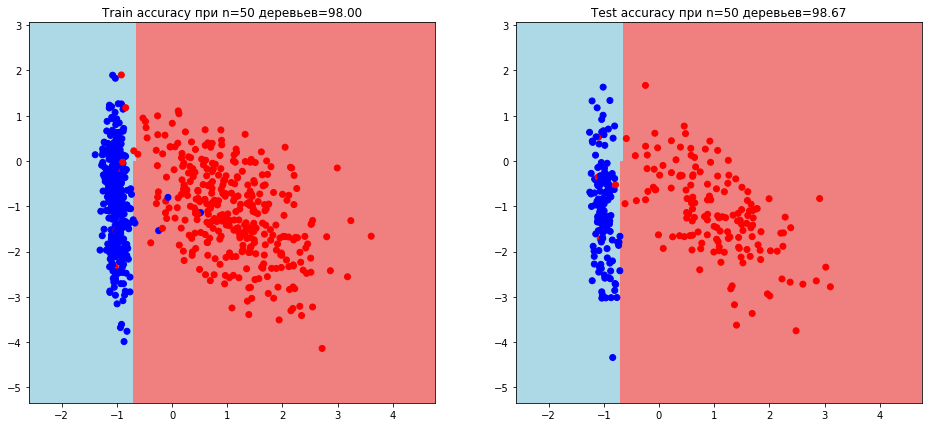

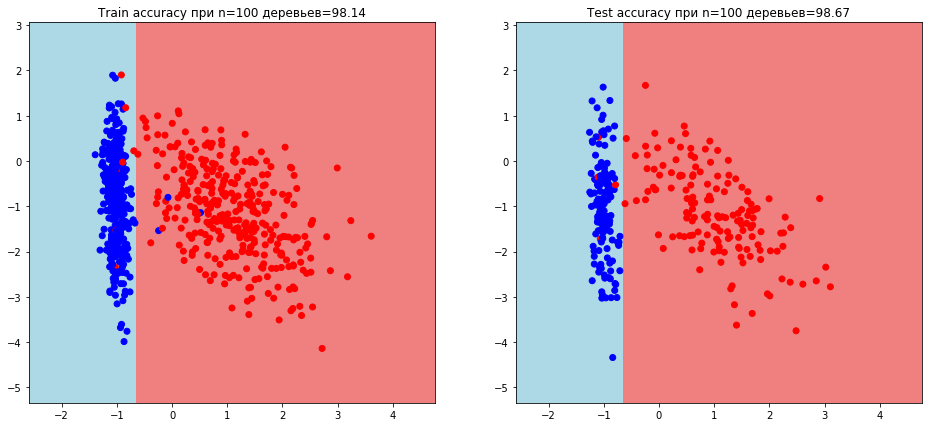

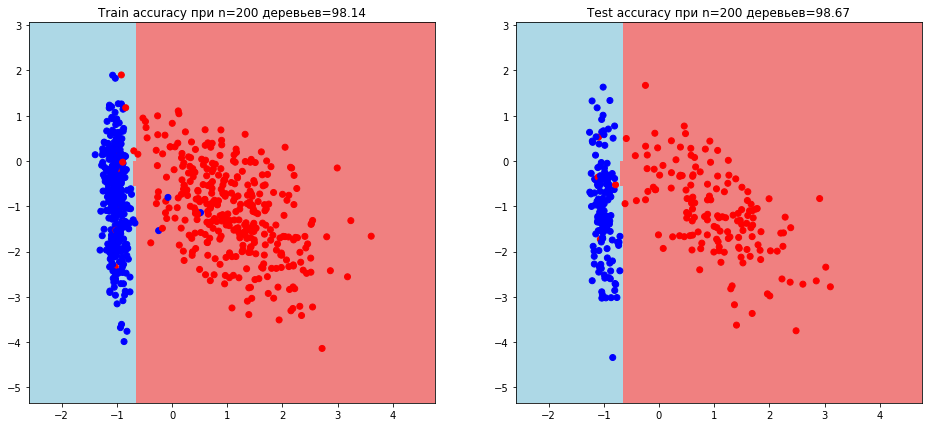

In [146]:
for i in n_forests:
    forest = RandomForestClassifier(n_trees = i) 
    forest.fit(train_data, train_labels)
    labels_pred_train = forest.predict(train_data)
    labels_pred_test = forest.predict(test_data)
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, labels_pred_train)
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, labels_pred_test)
    print_vizual (train_data,  test_data, forest, train_accuracy, test_accuracy,i)


Точность случайного леса возрастает при увеличении числа деревьев в нем. После 50 деревьев лес не переобучается. 

### Беггинг

In [164]:
# сгенерируем данные
n_samples=1000
classification_data, classification_labels = datasets.make_classification(n_samples=n_samples, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state = 50)

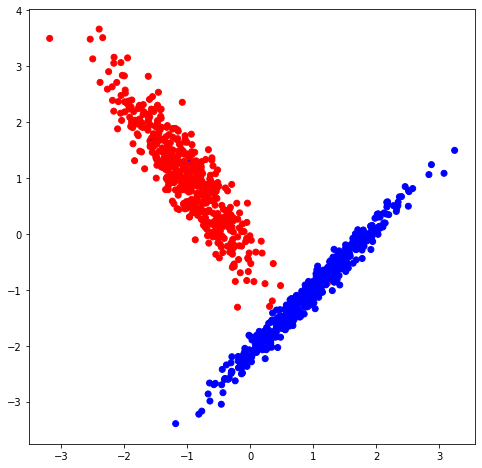

In [165]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Создадим случайный лес из 50 деревьев и обучим на всем объеме данных, фиксируя при этом номера индексов объектов, попавших в выборку (forest.sample_indexes) Используем Энтропию в качестве критерия оценки качества

In [166]:
forest = RandomForestClassifier(n_trees = 50, quality_criteria="Entropy" ) 
forest.fit(train_data, train_labels)

Определим индексы объектов, не попавших в бутсрап выборки (обучающая выборка)

In [167]:
indexes=np.array([i for i in range(n_samples)])

In [168]:
test_indexes=indexes[~np.isin(indexes, forest.sample_indexes)]

In [169]:
train_indexes =indexes[np.isin(indexes, forest.sample_indexes)]

Сформируем тестовую выборку из объектов, не попавших в обучющую выборку

In [170]:
test_data, test_lables=classification_data[test_indexes], classification_labels[test_indexes]

In [171]:
train_data, train_lables = classification_data[train_indexes], classification_labels[train_indexes]

In [172]:
train_lables_pred = forest.predict(train_data)

In [173]:
train_accuracy = accuracy_metric(train_lables, train_lables_pred)
train_accuracy

66.42857142857143

Протестируем на тестовой выборке

In [174]:
test_lables_pred =forest.predict(test_data)

Проверим качество

In [175]:
 test_accuracy = accuracy_metric(test_labels, test_lables_pred)

In [176]:
test_accuracy

53.0

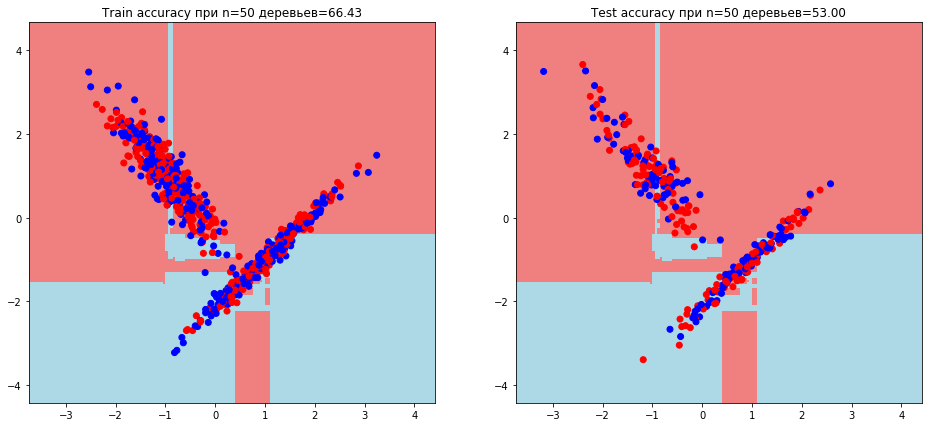

In [177]:
print_vizual (train_data,  test_data, forest, train_accuracy, test_accuracy, n_forests=50)

In [178]:
len(train_data)

700

In [179]:
len(test_data)

300